In [ ]:
!pip install d2l==1.0.0-alpha0
#!pip install d2l==0.17.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 1.3 MB/s 


#15.8 BERT(Bidirectional Encoder Representations from Transformers)
- BERT(Bidirectional Encoder Representations from Transformers)는 2018년 구글이 공개한 pre-trained 모델. Transformer를 이용해 구현, 위키피디아와 BooksCorpus와 같은 label이 없는 텍스트 데이터로 훈련.

- 일반적으로 BERT를 통해 label이 있는 다른 task에서 추가 훈련과 함께 hyperparameter를 재조정하면 성능이 높게 나옴.

 다른 작업에 대해 parameter 재조정을 위한 추가 훈련 과정을 fine-tuning이라고 함.
 
 *Bert를 사용한 모델링 과정 :관련 대랑 corpus -> BERT -> '분류를 원하는 데이터' -> LSTM, CNN 등의 머신러닝 모델 -> 분류*

대량의 corpus를 Encoder가 임베딩하고(언어 모델링), 이를 전이하여 fine-tuning 하고 task를 수행한다.(NLP Task)

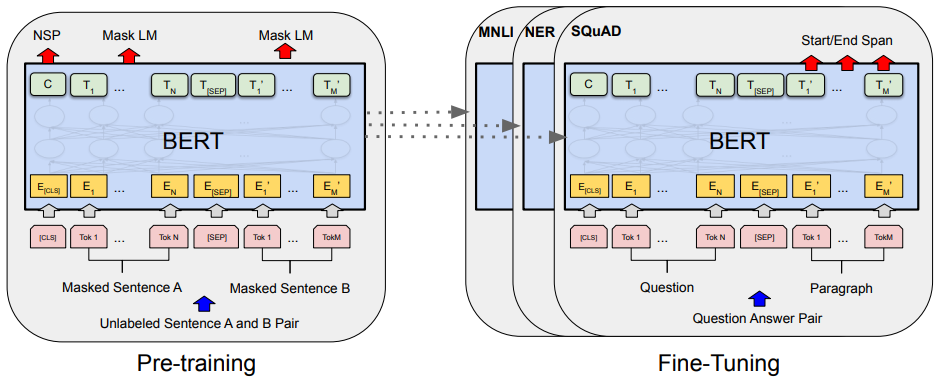

## 15.8.1 From Context-Independent to Context-Sensitive
- word2vec 및 GloVe는 모두 단어의 context에 관계없이 동일한 사전 훈련된 벡터를 동일한 단어에 할당.
- 정형적으로 모든 토큰 x의 context-independent 표현은 x만 입력으로 사용하는 함수 f(x)이다. Natural language의 다양하고 복잡한 의미를 감안할 때 context-independent 표현은 한계 존재. 
- 예를 들어, "a crane is flying"와 "a crane driver is came"이라는 문맥에서 "crane"이라는 단어는 완전히 다른 의미를 갖음. 따라서 문맥에 따라 같은 단어에 다른 표현이 할당될 수 있다.
- 단어의 표현이 문맥에 의존하는 단어 표현의 개발에 motivate 함. 따라서 token x의 상황에 맞는 표현은 x와 해당 context c(x)에 따라 함수 f(x,c(x)). 
- ELMo는 전체 시퀀스를 입력으로 사용해 입력 시퀀스의 각 단어에 표현을 할당하는 기능. 특히 pretrained bidirectional LSTM의 모든 intermediate layer 표현을 output 표현으로 결합. 그런 다음 ELMo 표현이 기존 모델에서 token의 원래 표현(예: GloVe)과 ELMo 표현을 연결하는 것과 같은 추가 기능으로 downstream 작업의 기존 supervised 모델에 추가됨. 
- 여기서 downstream task란 pre-training model을 사용할 때, 어떤 문제를 해결하기 위해 fine-tuning 하는지, 즉 해결하고자 하는 문제를 말한다.
- pretrained bidirectional LSTM 모델의 모든 가중치는 ELMo 표현이 추가된 후 고정됨. 반면 기존 supervised 모델은 특정 작업에 대해 특별히 사용자 지정됨.

## 15.8.2 From Task-Specific to Task-Agnostic
- *GPT(Generative Pre-Training)* 는 언어모델(Language Model)이다. 이전 단어들이 주어졌을 때 다음 단어가 무엇인지 맞추는 과정에서 pretrain한다. 문장 시작부터 순차적으로 계산한다는 점에서 unidirectional하다.
- GPT는 transformer에서 인코더를 제외하고 디코더만 사용한다. 구조를 살펴보면 다음의 그림과 같다.

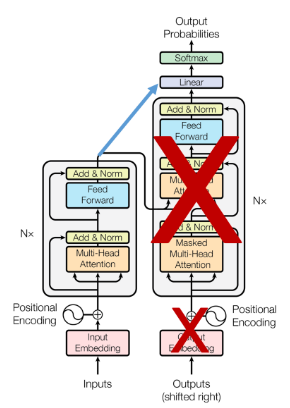

- Transformer decoder를 기반으로 하는 GPT는 text sequence를 나타내는 데 사용할 언어 모델을 pretrain한다. Downstream 작업에 GPT를 적용할 때 언어 모델의 출력은 작업의 레이블을 예측하기 위해 추가된 linear output layer에 제공된다. Pretrained 모델의 매개변수를 freeze 시키는 ELMo와 대조적으로, GPT는 downstream 작업의 supervised learning 동안 pretrained transformer decorder의 모든 parameter를 fine-tune한다.
- 그러나 언어 모델의 autoregressive 특성으로 인해 GPT는 왼쪽에서 오른쪽으로만 찾는다. "나는 현금을 예금하기 위해 은행에 갔다" 및 "앉기 위해 은행에 갔다" 컨텍스트에서 "은행"은 왼쪽 컨텍스트에 민감하므로 GPT는 "은행"에 대해 동일한 표현을 반환하지만 다른 의미를 가지고 있다.

## 15.8.3 BERT: Combining the Best of Both Worlds
- ELMo는 context를 양방향으로 인코딩하지만 task-specific architectures를 사용한다. GPT는 작업에 구애받지 않지만 컨텍스트를 왼쪽에서 오른쪽으로 인코딩한다. 두 세계의 장점을 결합한 BERT는 context를 양방향으로 인코딩하고 다양한 자연어 처리 작업을 위해 최소한의 아키텍처 변경이 필요하다.
- Pretrained transformer encoder를 사용하여 BERT는 양방향 context를 기반으로 모든 토큰을 나타낼 수 있다. Downstream 작업의 supervised learning 동안 BERT는 두 가지 측면에서 GPT와 유사하다. 
-> 첫째, BERT 표현은 작업의 특성에 따라 모델 아키텍처에 대한 최소한의 변경으로 추가된 output layer에 제공된다. 
-> 둘째, pretrained transformer encoder 모든 매개변수가 fine-tuned 되는 반면 추가 output layer는 scratch부터 trained 된다. 

elmo-gpt-bert.svg

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## 15.8.4 Input Representation
- NLP(Natural Language processing)에서 감정 분석 같은 작업은 단일 텍스트를 입력으로 사용, 반면 NLI(Natural Language Inference)와 같은 작업에서는 Input이 한 쌍의 텍스트 sequence. BERT Input sequence는 단일 텍스트와 텍스트 쌍을 명확하게 나타낸다. 
- NLP에서 BERT Input sequence는 특수 분류 토큰 "cls", 텍스트 sequence의 토큰 및 특수 분리 토큰 "sep"의 연결. NLI에서 BERT Input sequence는 "cls", 첫 번째 텍스트 sequence의 토큰, "sep", 두 번째 텍스트 sequence의 토큰 및 "sep"의 연결. 
-> "BERT Input sequence"라는 용어를 다른 유형의 "sequence"와 구별. 예를 들어, 하나의 BERT Input sequence는 하나의 텍스트 sequence 또는 두 개의 텍스트 sequence를 포함할 수 있다.

In [ ]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0과 1은 각각 segment A와 B를 표시
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

- BERT는 bidirectional architecture로 transformer encoder를 선택. transformer encoder에서 일반적으로 positional embedding은 BERT input 시퀀스의 모든 위치에 추가. 그러나 원래의 transformer encoder와 달리 BERT는 학습 가능한 positional embedding을 사용.
-> 즉, ***BERT input 시퀀스의 임베딩 = token 임베딩 + segment 임베딩 + positional 임베딩***


bert-input.svg

In [ ]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # BERT에서 위치 임베딩은 학습 가능하므로 충분히 긴 
        # 위치 임베딩 매개변수를 생성합니다.
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 'X'의 모양은 다음 코드 스니펫에서 변경되지 않은 상태로 유지됩니다. 
        # (배치 크기, 최대 시퀀스 길이, 'num_hiddens')
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

- vocabulary 크기가 10000이라고 가정. [BERTEncoder의 Inference]를 설명하기 위해 인스턴스를 만들고 매개변수를 초기화.

In [ ]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                      num_blks, dropout)

- '토큰'을 길이가 8인 2개의 BERT input sequence로 정의. 여기서 각 토큰은 어휘의 인덱스. 입력 토큰을 사용한 'BERTEncoder'의 순방향 추론은 각 '토큰'이 hyperparameter 'num_hiddens'에 의해 미리 정의된 길이를 가진 벡터로 표현되는 인코딩된 결과를 반환. 이 hyperparameter는 일반적으로 transformer encoder의 hidden size라고 한다.

In [ ]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

## 15.8.5 Pretraining Tasks
- BERTEncoder의 forward inference는 입력 텍스트의 각 토큰과 삽입된 특수 토큰 "cls" 및 "seq"의 BERT 표현을 제공. 이런 표현을 사용해 BERT를 pretraining 하기 위한 loss func. 계산. 사전 훈련은 masked language modeling과 next sentence prediction 두 가지 작업으로 구성.



##15.8.5.1 Masked Language Modeling
- BERT는 사전 훈련을 위해 입력 텍스트의 15% 단어를 랜덤으로 마스킹합니다. 이후 신경망이 가려진 단어들을 예측하도록 합니다. 쉽게 말해 빈칸 뚫고 맞추기 학습입니다.
랜덤으로 선택된 15% 단어들은 다시 다음과 같은 비율로 규칙이 적용됩니다.

[규칙 적용]
1.  80% 단어들은 [MASK]로 변경
예) The man went to the store -> The man went to the [MASK]
2. 10% 단어들은 램덤으로 단어 변경 
예) The man went to the store -> The man went to the dog
3. 10% 단어들은 동일하게 유지
예) The man went to the store -> The man went to the store

 - 이는 [MASK]만 사용할 경우 [MASK] 토큰이 파인튜닝 단계에선 나타나지 않기  때문에 사전 학습 단계와 파인튜닝 단계에서의 불일치 문제를 피하기 위함입니다. 

- 예를 들어, 'My dog is cute. he likes playing'이란 문장이 있고, 서브워드 토크나이저에 의해 ['my', 'dog', 'is' 'cute', 'he', 'likes', 'play', '##ing']로 토큰화되었다고 합시다. BERT의 입력으로 사용되면서 아래처럼 변경될 수 있습니다.

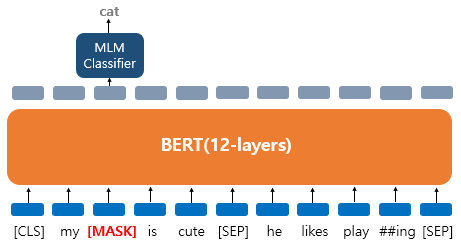
- 'dog' 토큰이 [MASK]로 변경되었고 BERT는 원래 단어를 맞추려고 합니다. 여기서 출력층에 있는 다른 위치의 벡터들은 예측과 학습에 사용되지 않고, 오직 'dog' 위치의 출력층 벡터만이 사용됩니다. 구체적으로는 BERT의 손실 함수에서 다른 위치에서의 예측은 무시합니다. 출력층에서는 예측을 위해 단어 집합의 크기만큼의 밀집층(Dense layer)에 소프트맥스 함수가 사용된 1개의 층을 사용하여 원래 단어가 무엇인지를 맞추게 됩니다.


In [ ]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # batch_size` = 2, `num_pred_positions` = 3이라고 가정하면
        # `batch_idx`는 `torch.tensor([0, 0, 0, 1, 1, 1])`입니다.
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

- [MaskLM의 forward inference]를 보여주기 위해 instance mlm을 생성하고 초기화. BERTEncoder의 forward inference에서 encode_X는 2개의 BERT input sequence를 나타냄. mlm_positions를 encoding_X의 BERT input sequence에서 예측할 3개의 인덱스로 정의합니다. mlm의 forward inference은 encoding_X의 모든 마스킹된 위치 mlm_positions에서 예측 결과인 mlm_Y_hat을 반환.

In [ ]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 3, 10000])

- 마스크 아래 예측된 토큰 mlm_Y_hat의 truth label mlm_Y를 사용해 BERT pretraining에서 masked language model 작업의 교차 엔트로피 손실을 계산할 수 있습니다.

In [ ]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

###15.8.5.2 Next Sentence Prediction (NSP, 다음 문장 예측)
- masked language modeling은 단어를 표현하기 위한 bidirectional context를 인코딩할 수 있지만 텍스트 쌍 간의 논리적 관계를 명시적으로 모델링하지는 않는다. 
BERT는 두 개의 문장을 준 후에 이 문장이 이어지는 문장인지 아닌지를 맞추는 방식으로 훈련한다. 이를 위해 50:50 비율로 실제 이어지는 두 개의 문장과 랜덤으로 이어붙인 두 개의 문장이 주어진다. 이를 각각 Sentence A, Sentence B라고 하였을 때, 아래는 문장의 연속성을 확인한 경우와 그렇지 않은 경우를 보여준다.

---
이어지는 문장인 경우

Sentence A : The man went to the store.

Sentence B : He bought a gallon of milk.

Label = IsNextSentence

이어지는 문장이 아닌 경우

Sentence A : The man went to the store.

Sentence B : dogs are so cute.

Label = NotNextSentence

---
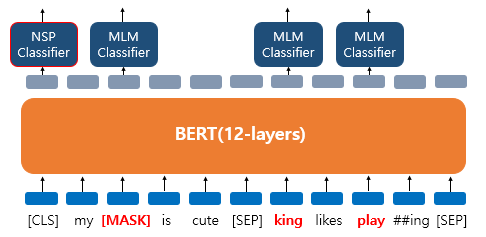

- BERT의 입력에선 [SEP]라는 특별 토큰을 사용해서 문장을 구분한다. 첫 번째 문장의 끝에 [SEP] 토큰을 넣고, 두 번째 문장이 끝나면 역시 [SEP] 토큰을 붙여준다. 그리고 이 두 문장이 실제 이어지는 문장인지 아닌지를 [CLS] 토큰 위치의 출력층에서 이진 분류 문제를 풀도록 한다. [CLS] 토큰은 BERT가 분류 문제를 풀기 위해 추가된 특별 토큰이다. 또한 위의 그림처럼 Masked Language Model과 다음 문장 예측은 따로 학습하는 것이 아니라 loss를 합하여 학습이 동시에 이루어집니다.
- BERT가 언어 모델 외에도 다음 문장 예측이라는 태스크를 학습하는 이유는 QA(Question Answering)나 NLI(Natural Language Inference)와 같이 두 문장의 관계를 이해하는 것이 중요한 태스크들도 있기 때문이다.


In [ ]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

[NextSentencePred의 forward inference] instance가 각 BERT input sequence에 대해 binary prediction을 반환하는 것을 볼 수 있다.

In [ ]:
# 기본적으로 PyTorch는 mxnet에서 볼 수 있듯이 텐서를 평면화하지 않습니다. 
# 여기서 flatten=True이면 입력 데이터의 첫 번째 축을 제외한 모든 축이 함께 축소됩니다.
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP용 input_shape: (배치 크기, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

- 2개의 binary classification의 cross-entropy loss도 계산할 수 있음.

In [ ]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

- 앞서 언급한 두 pretraining task의 모든 레이블은 수동 레이블 지정 없이 pretraining corpus에서 간단하게 얻을 수 있다.

## 15.8.6 Putting All Things Together
BERT를 사전훈련 할 때 최종 loss function은 masked language modeling과 next sentence prediction을 위한 loss function의 선형 조합이다. 즉, 세 가지 클래스 BERTEncoder, MaskLM 및 NextSentencePred를 instantiating하여 BERTModel 클래스를 정의할 수 있다. Forward inference는 인코딩된 BERT 표현 coded_X, masked language modeling "mlm_Y_hat"의 prediction 및 next sentence prediction "nsp_Y_hat"을 반환한다.

In [ ]:
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 다음 문장 예측을 위한 MLP classifier의 은닉층.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## 15.8.7. Summary
- word2vec 및 GloVe와 같은 단어 embedding model은 context independent. 단어의 컨텍스트(있는 경우)에 관계없이 동일한 pretrained vector를 동일한 단어에 할당한다. Natural language의 다의미 또는 복잡한 의미를 잘 처리하는 것은 어렵다.
- ELMo 및 GPT와 같은  context-sensitive word representation의 경우 단어 표현은 문맥에 따라 다르다.
- ELMo는 컨텍스트를 bidirection으로 인코딩하지만 작업별 아키텍처를 사용한다. GPT는 task에 구애받지 않지만 컨텍스트를 왼쪽에서 오른쪽으로 인코딩한다.
- BERT는 양방향으로 컨텍스트를 인코딩하고 광범위한 자연어 처리 작업에 대해 아키텍처 변경을 최소화해야 한다.
- ***BERT input sequence의 임베딩은 token 임베딩, segment 임베딩 및 positional 임베딩의 합***이다.
- Pretraining BERT는 masked language modeling과 next sentence prediction의 두 가지 task로 구성. 전자는 단어를 표현하기 위해 bidirectional context를 인코딩할 수 있는 반면, 후자는 텍스트 쌍 간의 논리적 관계를 explit하게 모델링한다.

##15.8.8. Exercises
1. All other things being equal, will a masked language model require more or fewer pretraining steps to converge than a left-to-right language model? Why?

2. In the original implementation of BERT, the positionwise feed-forward network in 'BERTEncoder' (via 'd2l.TransformerEncoderBlock') and the fully connected layer in 'MaskLM' both use the Gaussian error linear unit (GELU) :cite:['Hendrycks & Gimpel, 2016b'] as the activation function. Research into the difference between GELU and ReLU.